In [2]:
# Load data
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functions import Config
from models import GNNChoiceModel
from data_process import load_data, spatial_choice_dataset_interact

import matplotlib.cm as cm
import matplotlib.colors as mcolors

plt.rcParams["font.family"] = "Helvetica"
plt.rcParams["axes.xmargin"] = 0.01
plt.rcParams["axes.ymargin"] = 0.01


comm, hh, edge_index, distance_to_work = load_data()

comm_features = [
    "pop_density",
    "white_prop",
    "black_prop",
    "single_res",
    "multi_res",
    "office",
    "land_mix",
    "transit_a_scaled",
    "med_house_age_scaled",
    "med_value_scaled",
    "h_units_scaled",
    "median_inc_scaled",
]


hh_features = ["hh_income_scaled", "race_white", "race_black"]

# Load dataset
my_dataset = spatial_choice_dataset_interact

i = 0
test_idx = np.arange(i, len(hh), 10)
train_idx = np.setdiff1d(np.arange(len(hh)), test_idx)
train_dataset = my_dataset(
    comm, hh.loc[train_idx, :], distance_to_work[train_idx], comm_features, hh_features
)
test_dataset = my_dataset(
    comm, hh.loc[test_idx, :], distance_to_work[test_idx], comm_features, hh_features
)

# Load GNN model
device = torch.device("cpu")
config = Config()
config.bs = 32
config.num_hidden = 64
config.dropout = 0
config.model = "GATConv"
config.heads = 4  # Number of attention heads for GAT
config.residual = True
config.seed = 100

gnn2 = GNNChoiceModel(
    train_dataset[0][0].shape[-1],
    config.num_hidden,
    edge_index,
    dropout=config.dropout,
    heads=config.heads,
    residual=config.residual,
    n_layer=2,
)
gnn2.load_state_dict(torch.load("log/Deepchoice_GATConv_2025-03-16_11-43-35.pth"))

feature_names = train_dataset.feature_names
# feature_names = comm_features + ["distance_to_work"] + hh_features
dataset = test_dataset
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=len(dataset), shuffle=False
)

/var/folders/v6/5jphmjb1409bj0_xw7mj_7dc0000gn/T/ipykernel_7007/376624808.py:72: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gnn2.load_state_dict(torch.load("log/Deepchoic

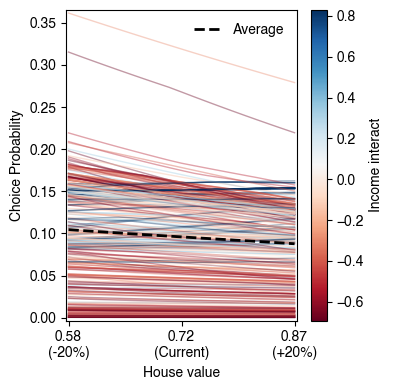

In [5]:
# For the north side, I will choose LAKE VIEW, id=5, median_inc=80k+, white_prop=85%, counts=373
comm_id = 5
main_factor = "med_value_scaled"
second_factor = "home_income_interact"
scope = 0.20  # 10% of the range
n = 10  # number of points to test on one side
main_idx = feature_names.index(main_factor)
second_idx = feature_names.index(second_factor)

results = []
inputs, target = next(iter(data_loader))  # inputs: (bs, num_comm, num_features)
first_factor_data = inputs[:, comm_id, main_idx].clone()
second_factor_data = inputs[:, comm_id, second_idx].cpu().detach().numpy()
for x in np.linspace(1 - scope, 1 + scope, 2 * n - 1):
    inputs[:, comm_id, main_idx] = first_factor_data * x
    outputs = gnn2(inputs).cpu().detach().numpy()  # (bs, num_comm)
    results.append(outputs[:, comm_id])

results = np.array(results)  # (2*n-1, bs)
results = np.exp(results)

# Normalize the income values to a range suitable for colormap
norm = mcolors.Normalize(vmin=min(second_factor_data), vmax=max(second_factor_data))
colormap = cm.RdBu  # Choose a colormap (e.g., viridis, plasma, etc.)
fig, ax = plt.subplots(figsize=(4, 4))
current_value = first_factor_data[i].item()
for i in range(second_factor_data.shape[0]):
    ax.plot(
        np.linspace(-1, 1, 2 * n - 1),
        results[:, i],
        color=colormap(norm(second_factor_data[i])),
        alpha=0.4,
        linewidth=1,
    )
ax.plot(
    np.linspace(-1, 1, 2 * n - 1),
    results.mean(axis=1),
    color="Black",
    linewidth=2,
    linestyle="--",
    label="Average",
)
ax.set_xlabel("House value")
ax.set_ylabel("Choice Probability")
ax.legend(frameon=False)
ax.set_xticks([-1, 0, 1])
ax.set_xticklabels(
    [
        f"{current_value * (1 - scope):.2f}\n(-{scope * 100:.0f}%)",
        f"{current_value:.2f}\n(Current)",
        f"{current_value * (1 + scope):.2f}\n(+{scope * 100:.0f}%)",
    ]
)

# Add a colorbar for reference
sm = cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, label="Income interact")
fig.tight_layout()
fig.savefig("Lake_view_house_value.pdf")

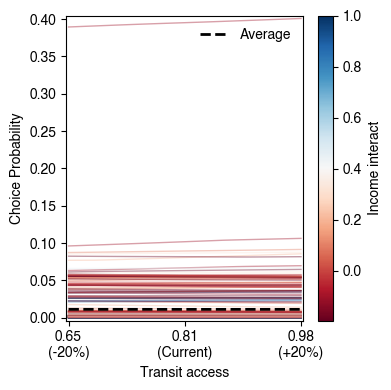

In [4]:
# For the south side, I will choose SOUTH SHORE, id=42, median_inc=24k+, white_prop=3.2%, black_prop=94%, counts=48
comm_id = 70
main_factor = "transit_a_scaled"
second_factor = "home_income_interact"
scope = 0.20  # 10% of the range
n = 10  # number of points to test on one side
main_idx = feature_names.index(main_factor)
second_idx = feature_names.index(second_factor)

results = []
inputs, target = next(iter(data_loader))  # inputs: (bs, num_comm, num_features)
first_factor_data = inputs[:, comm_id, main_idx].clone()
second_factor_data = inputs[:, comm_id, second_idx].cpu().detach().numpy()
for x in np.linspace(1 - scope, 1 + scope, 2 * n - 1):
    inputs[:, comm_id, main_idx] = first_factor_data * x
    outputs = gnn2(inputs).cpu().detach().numpy()  # (bs, num_comm)
    results.append(outputs[:, comm_id])

results = np.array(results)  # (2*n-1, bs)
results = np.exp(results)

# Normalize the income values to a range suitable for colormap
norm = mcolors.Normalize(vmin=min(second_factor_data), vmax=min(1, max(second_factor_data)))
colormap = cm.RdBu  # Choose a colormap (e.g., viridis, plasma, etc.)
fig, ax = plt.subplots(figsize=(4, 4))
current_value = first_factor_data[1].item()
for i in range(second_factor_data.shape[0]):
    ax.plot(
        np.linspace(-1, 1, 2 * n - 1),
        results[:, i],
        color=colormap(norm(second_factor_data[i])),
        alpha=0.4,
        linewidth=1,
    )
ax.plot(
    np.linspace(-1, 1, 2 * n - 1),
    results.mean(axis=1),
    color="Black",
    linewidth=2,
    linestyle="--",
    label="Average",
)

ax.set_xlabel("Transit access")
ax.set_ylabel("Choice Probability")
ax.legend(frameon=False)
ax.set_xticks([-1, 0, 1])
# ax.set_ylim(0, 0.11)
ax.set_xticklabels(
    [
        f"{current_value * (1 - scope):.2f}\n(-{scope * 100:.0f}%)",
        f"{current_value:.2f}\n(Current)",
        f"{current_value * (1 + scope):.2f}\n(+{scope * 100:.0f}%)",
    ]
)

# Add a colorbar for reference
sm = cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, label="Income interact")
fig.tight_layout()
fig.savefig("South_shore_transit.pdf")